In [8]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed
import pygad

# Collateralized Ad Auction

An ad auction is an auction where advertisers are bidding for a user's attention through an ad distributor (Google, Facebook, etc.). The advertiser pays the distributor some amount of money for their ad to show up on the user's browser.

Ads carry with them some value for the advertiser and, crucially, some value for the general social welfare. The social welfare value often comes through the ad's intended effect and truthfulness. For example, an ad that denies climate change would have a negative social welfare value, while one that encourages using clean energy might have a positive social welfare value.

Let's assume the auctioneer knows the true social welfare value for any ad. A penalized ad auction is one in which the advertiser who wins the auction pays an additional cost as a function of the ad's social welfare value. (this can equivalently be implemented through a collateralization mechanism with probabalistic auditing and loss of the collateral as a penalty).

This code implements a collateralized second-price ad auction. Advertisers place a bid only if their value is greater than the expected payment value plus the known penalty (or expected collateralization) payment for their ad. Their payment is the second highest bid. This ensures that advertisers bid their true values.

The advertiser's value is denoted $v$ where $v_1, v_2, ...$ are the highest value, second highest value, etc. The social welfare value is denoted $e$ where $e_1$ is the social welfare value of the ad with the highest advertiser value. Given a collateralization function ($C$) that returns the collateralization value for a given $e$, $\tau$ is a function that returns $C(e) + \mathbb{E}(v_2)$. An advertiser will only bid if their $v_i > \tau(v_i, e_i)$.

## Data

X data was collected from the X community notes files as well as from the X API. Posts were pulled from the API if they had a community note with at least 400 "HELPFUL" ratings. Post externality cost per 1000 impressions (CPM) was calculated by giving note types values between -3 and 3, and then subtracting the average rating where 'HELPFUL' = 1, 'SOMEWHAT_HELPFUL' = 0, and 'NOT_HELPFUL' = -1.

$$e = (\text{note score} - \text{rating score}) * \text{impression count per month} * 0.00153$$

Average advertiser cost per first action data was pulled from [this website](https://www.webfx.com/social-media/pricing/how-much-does-it-cost-to-advertise-on-twitter/).

Post 'advertiser value' will be calculated during a simulation using this formula:
$$v = \text{random cost per action} * \frac{retweets+replies+likes+quotes+bookmarks}{impressions/1000}$$





In [25]:
tweet_data = pd.read_csv('full_tweets.csv')

print(tweet_data[['externality_cpm', 'action_count_per_1000_impressions']].describe())

average_ad_costs = [0.13,0.38,0.63,0.88,1.255,1.755,2.255,2.755,3.255]
# the 'not applicable' 2.5% was devided and distributed evenly to the other
# categories to create a pmf that sums to 1
ad_cost_probabilities = [0.1527777778,
                         0.1777777778,
                         0.1527777778,
                         0.1277777778,
                         0.09447777778,
                         0.08607777778,
                         0.06947777778,
                         0.08607777778,
                         0.05277777778]
# example usage: rng.choice(average_ad_costs, num_draws, p=ad_cost_probabilities) 

       externality_cpm  action_count_per_1000_impressions
count     11853.000000                       11853.000000
mean         -0.795309                           7.261223
std           0.412564                           8.994813
min          -1.530000                           0.000450
25%          -1.122226                           1.650213
50%          -0.712418                           4.360297
75%          -0.456341                           9.392109
max           0.176109                         125.404512


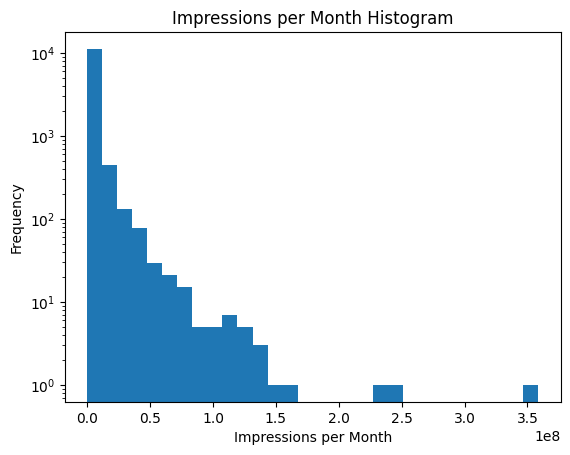

count    1.185300e+04
mean     3.429005e+06
std      1.001059e+07
min      1.322500e+02
25%      2.335942e+05
50%      7.622885e+05
75%      2.591065e+06
max      3.584362e+08
Name: impressions_per_month, dtype: float64


In [26]:
tweet_data['created_at_dt'] = pd.to_datetime(tweet_data['created_at'])
date_pulled = pd.to_datetime('02/02/2025')
tweet_data['days_old'] = (date_pulled - tweet_data['created_at_dt']).dt.days
tweet_data['months_old'] = tweet_data['days_old']/30

# plot histogram of impressions per month
plt.hist(tweet_data['impression_count']/(tweet_data['days_old']/30), bins=30, log=True)
plt.xlabel('Impressions per Month')
plt.ylabel('Frequency')
plt.title('Impressions per Month Histogram')
plt.show()

tweet_data['impressions_per_month'] = tweet_data['impression_count']/(tweet_data['months_old'])

print(tweet_data['impressions_per_month'].describe())

       ext_dollars_per_month  action_per_month
count           11853.000000      1.185300e+04
mean            -1835.414340      2.019944e+04
std              4740.358814      6.284877e+04
min            -96415.572224      3.105590e-01
25%             -1520.091792      6.615058e+02
50%              -521.605463      2.839052e+03
75%              -178.716623      1.330448e+04
max              2774.806736      1.611199e+06


C:\Users\gabem\AppData\Local\Temp\ipykernel_28492\1843632283.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


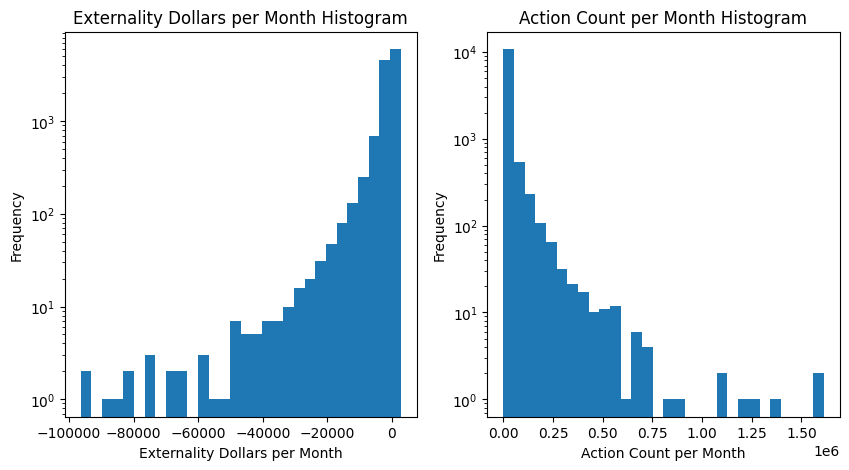

In [27]:
# user per month
externality_cost_per_impression = 0.00153

externality_max = tweet_data['externality'].abs().max()
tweet_data['ext_dollars_per_month'] = ((tweet_data['externality']/externality_max) * 
                                       tweet_data['impressions_per_month'] * 
                                       externality_cost_per_impression)
tweet_data['ext_per_month'] = ((tweet_data['externality']/externality_max) * 
                                       tweet_data['impressions_per_month'])

# producer actions per month
tweet_data['action_per_month'] = tweet_data['action_count'] / tweet_data['months_old']

print(tweet_data[['ext_dollars_per_month', 'action_per_month']].describe())

# plot histograms of externality and action per month
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(tweet_data['ext_dollars_per_month'], bins=30, log=True)
axs[0].set_xlabel('Externality Dollars per Month')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Externality Dollars per Month Histogram')

axs[1].hist(tweet_data['action_per_month'], bins=30, log=True)
axs[1].set_xlabel('Action Count per Month')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Action Count per Month Histogram')

fig.show()

## Parameters

- `num_advertisers`: The number of advertisers participating in the auction
- `tau`: A function that returns the expected payment given an ad
- `ad_distribution`: A function that initializes $(v_i, e_i)$ pairs according to a given distribution
- `value_ratio`: The ratio of the advertiser value to the social welfare value
- `k`: number of allocation spots per auction (in results look at addition of e and v values for all winners)

In [5]:
random_seed = 123
random.seed(random_seed)
rng = np.random.default_rng(random_seed)

num_auctions = 100
num_advertisers = 100
tau = lambda v, e: -0.5*e + 0.5
k = 1

def ad_distribution(data, num_advertisers, rng):
    sample = data.sample(n=num_advertisers, random_state=rng)
    advertisers = [(row['v'], row['e']) for index, row in sample.iterrows()]
    # v = rng.choice(average_ad_costs, 1, p=ad_cost_probabilities) * tweet_data['action_count_per_1000_impressions'].iloc[random_i]
    # e = tweet_data['externality_cpm'][random_i]
    return advertisers

## Auction
1. Initialize advertiser ad values according to parameters
2. Run counterfactual second-price auction
 - Advertisers decide on bid ($v$, honest)
 - Everyone bids
 - Record $(v_1, e_1, v_1+e_1) = w_{vcg}$
3. Run collateralized second-price auction
 - Advertisers decide on bid ($v$, honest)
 - Advertisers with $v_i > \tau(v_i, e_i)$ place bid
 - Record $(v_1, e_1, v_1+e_1) = w_{coll}$

 Make change to allow for any number of accepted bids (k). If no advertisers pass the tau check, output welfare of 0. Output v-vector that is v1, v1+v2, v1+...+vk etc. Visualize:
 - histogram of welfare for given k
 - line (x=k, y=avg welfare for k)

In [23]:
def auction_objective(w_results, ext_cost=0.00153, ad_scaler=1, ext_scaler=1):
    return (w_results[0]/ad_scaler)+((w_results[1]/ext_scaler)*ext_cost)

def run_auction(advertisers, tau, k=1):

    # run counterfactual auction
    counterfactual_bids = []
    for ad in advertisers:
        counterfactual_bids.append(ad)
    ## sort bids according to advertiser value
    counterfactual_bids.sort(key=lambda x: x[0])
    ## get the top k bids
    top_bids = counterfactual_bids[-k:]
    w_vcg = (sum([b[0] for b in top_bids]), sum([b[1] for b in top_bids]))

    # run collateralized auction
    collateralized_bids = []
    for ad in advertisers:
        if ad[0] >= tau(ad[0], ad[1]):
            collateralized_bids.append(ad)
    ## sort bids according to advertiser value
    collateralized_bids.sort(key=lambda x: x[0])
    top_bids = collateralized_bids[-k:]
    w_coll = (sum([b[0] for b in top_bids]), sum([b[1] for b in top_bids]))

    return w_vcg, w_coll

def run_auction_set(m, b, advertisers, k=1):
    w_vcg = []
    w_coll = []
    tau = lambda v, e: m*e + b
        
    for advertiser_set in advertisers:
            w_vcg_i, w_coll_i = run_auction(advertiser_set, tau, k)
            w_vcg.append(w_vcg_i)
            w_coll.append(w_coll_i)
            
    w_vcg_objective = [auction_objective(w) for w in w_vcg]
    w_coll_objective = [auction_objective(w) for w in w_coll]
    
    w_vcg_ad = [w[0] for w in w_vcg]
    w_coll_ad = [w[0] for w in w_coll]
    w_vcg_ex = [w[1] for w in w_vcg]
    w_coll_ex = [w[1] for w in w_coll]
    individual_welfares = {
        'vcg_ad': w_vcg_ad,
        'coll_ad': w_coll_ad,
        'vcg_ex': w_vcg_ex,
        'coll_ex': w_coll_ex
    }
    
    avg_vcg_objective = np.mean(w_vcg_objective)
    avg_coll_objective = np.mean(w_coll_objective)
    
    return (m, b, avg_coll_objective, avg_vcg_objective, w_coll_objective, w_vcg_objective, individual_welfares)

def run_auctions(num_auctions, 
                 num_advertisers, 
                 slope_magnitude_max, 
                 slope_step_size,
                 intercept_min,
                 intercept_max,
                 intercept_step_size,
                 data, 
                 k=1, 
                 rng=None):
    # output variables
    w_vcg = []
    w_coll = []
    advertisers = [ad_distribution(data, num_advertisers, rng) for _ in range(num_auctions)]
    
    grid = [
        (m, b) 
        for m in np.arange(-slope_magnitude_max, 0, slope_step_size) 
        for b in np.arange(intercept_min, intercept_max, intercept_step_size)
    ]
    
    results = Parallel(n_jobs=-1)(
        delayed(run_auction_set)(m, b, advertisers, k) 
        for (m, b) in tqdm(grid, desc='Auction Simulations')
    )
    # results[i] = (m, b, avg_coll_objective, avg_vcg_objective, w_coll_objective, w_vcg_objective)
    best_result = max(results, key=lambda x: x[2])
    best_m, best_b, best_avg_coll_welfare, best_avg_vcg_welfare, best_coll_welfare, best_vcg_welfare, best_individual_welfares = best_result
    best_line = (best_m, best_b)
            
    print('========================================')
    print('Finished Running Simulations')
    print(f'Best Tau: ad_value = {best_line[0]}*social_welfare + {best_line[1]}')
    print(f'Avg Collateralized Objective: {best_avg_coll_welfare}')
    # print(f'Avg VCG Welfare: {best_avg_vcg_welfare}')
    # print(f'\nChange in Total Welfare: {best_avg_coll_welfare - best_avg_vcg_welfare}')
    print('========================================')

    return {
        'advertisers': advertisers,
        'tau': best_line,
        'avg_coll_welfare': best_avg_coll_welfare,
        'avg_vcg_welfare': best_avg_vcg_welfare,
        'coll_welfare': best_coll_welfare,
        'vcg_welfare': best_vcg_welfare,
        'individual_welfares': best_individual_welfares
    }

def print_stats(auction_output, ad_scaler=1, ext_scaler=1):
    
    individual_welfares = auction_output['individual_welfares']
    w_vcg_ad = [v*ad_scaler for v in individual_welfares['vcg_ad']]
    w_coll_ad = [v*ad_scaler for v in individual_welfares['coll_ad']]
    w_vcg_ex = [e*ext_scaler for e in individual_welfares['vcg_ex']]
    w_coll_ex = [e*ext_scaler for e in individual_welfares['coll_ex']]
    
    print('\n========================================')
    print('Welfare Averages')
    print(f'Avg. VCG Advertiser Welfare: {np.mean(w_vcg_ad):.2f}')
    print(f'Avg. Collateralized Advertiser Welfare: {np.mean(w_coll_ad):.2f}')
    print(f'Avg. VCG Social Welfare: {np.mean(w_vcg_ex):.2f}')
    print(f'Avg. Collateralized Social Welfare: {np.mean(w_coll_ex):.2f}')
    print(f'\nAvg. Change in Advertiser Welfare: {np.mean(w_coll_ad) - np.mean(w_vcg_ad):.2f}')
    print(f'Avg. Change in Social Welfare: {np.mean(w_coll_ex) - np.mean(w_vcg_ex):.2f}')
    print(f'\nAvg. VCG Total Welfare: {np.mean([ad+ex for ad, ex in zip(w_vcg_ad, w_vcg_ex)]):.2f}')
    print(f'Avg. Collateralized Total Welfare: {np.mean([ad+ex for ad, ex in zip(w_coll_ad, w_coll_ex)]):.2f}')
    print(f'Avg. Change in Total Welfare: {np.mean([ad+ex for ad, ex in zip(w_coll_ad, w_coll_ex)]) - np.mean([ad+ex for ad, ex in zip(w_vcg_ad, w_vcg_ex)]):.2f}')
    print('========================================\n')

def plot_auctions(auction_output, ad_scaler=1, ext_scaler=1):
    counterfactual_welfare = auction_output['vcg_welfare']
    collateralized_welfare = auction_output['coll_welfare']
    
    individual_welfares = auction_output['individual_welfares']
    w_vcg_ad = [v*ad_scaler for v in individual_welfares['vcg_ad']]
    w_coll_ad = [v*ad_scaler for v in individual_welfares['coll_ad']]
    w_vcg_ex = [e*ext_scaler for e in individual_welfares['vcg_ex']]
    w_coll_ex = [e*ext_scaler for e in individual_welfares['coll_ex']]
    
    # plot welfare histograms
    plt.hist([counterfactual_welfare, collateralized_welfare], bins=30, alpha=0.5, color=['red', 'blue'], label=['Counterfactual', 'Collateralized'])
    plt.legend(loc='upper right')
    plt.xlabel('Welfare')
    plt.ylabel('Frequency')
    plt.title('Welfare Distribution')
    plt.show()
    
    # plot individual advertiser and externality welfares
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].hist([w_vcg_ad, w_coll_ad], bins=30, alpha=0.5, color=['red', 'blue'], label=['Counterfactual', 'Collateralized'])
    axs[0].legend(loc='upper right')
    axs[0].set_xlabel('Advertiser Welfare')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Advertiser Welfare Distribution')
    
    axs[1].hist([w_vcg_ex, w_coll_ex], bins=30, alpha=0.5, color=['red', 'blue'], label=['Counterfactual', 'Collateralized'])
    axs[1].legend(loc='upper right')
    axs[1].set_xlabel('Externality Welfare')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Externality Welfare Distribution')
    
    fig.show()
    
    
def plot_advertisers(auction_output, ad_scaler=1, ext_scaler=1):
    # plot all advertisers and best line
    advertisers = auction_output['advertisers']
    tau = auction_output['tau']
    v = [ad[0]*ad_scaler for advertisers_set in advertisers for ad in advertisers_set]
    e = [ad[1]*ext_scaler for advertisers_set in advertisers for ad in advertisers_set]
    
    # clear plot
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    
    axs.scatter(e, v, alpha=0.5)
    axs.plot([min(e), max(e)], [(tau[0]*min(e)+tau[1])*ad_scaler, (tau[0]*max(e)+tau[1])*ad_scaler], color='red')
    axs.set_ylabel('Advertiser Value')
    axs.set_xlabel('Externality Value')
    axs.set_title('Social Welfare Values vs Advertiser Values with Best Tau Line')
    fig.show()
    

    

Auction Simulations: 100%|██████████| 3000/3000 [00:12<00:00, 232.54it/s]


Finished Running Simulations
Best Tau: ad_value = -13.900000000000004*social_welfare + -610
Avg Collateralized Objective: 18792.39336151799

Welfare Averages
Avg. VCG Advertiser Welfare: 289213.88
Avg. Collateralized Advertiser Welfare: 269732.30
Avg. VCG Social Welfare: -12996.71
Avg. Collateralized Social Welfare: -9089.82

Avg. Change in Advertiser Welfare: -19481.58
Avg. Change in Social Welfare: 3906.89

Avg. VCG Total Welfare: 276217.17
Avg. Collateralized Total Welfare: 260642.48
Avg. Change in Total Welfare: -15574.68



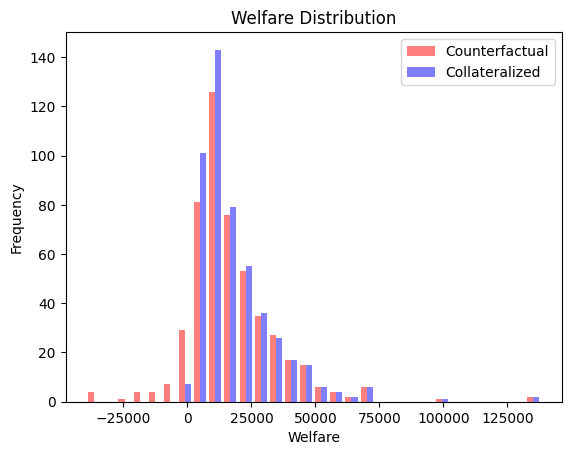

C:\Users\gabem\AppData\Local\Temp\ipykernel_28492\3736436940.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\gabem\AppData\Local\Temp\ipykernel_28492\3736436940.py:176: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


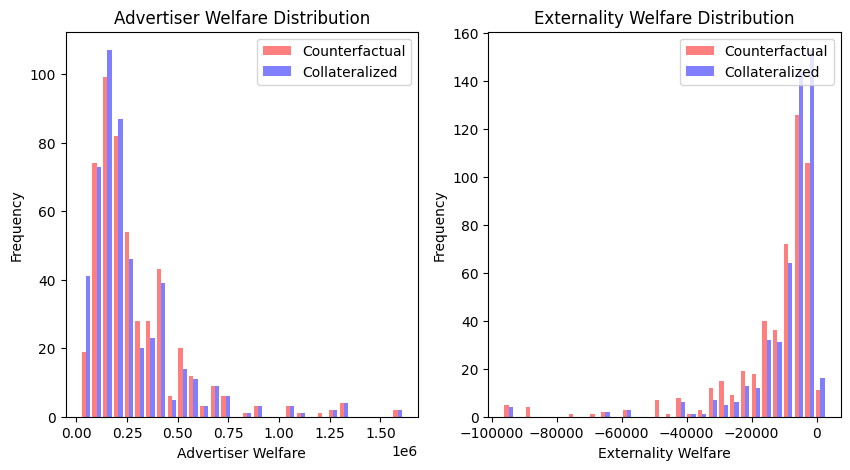

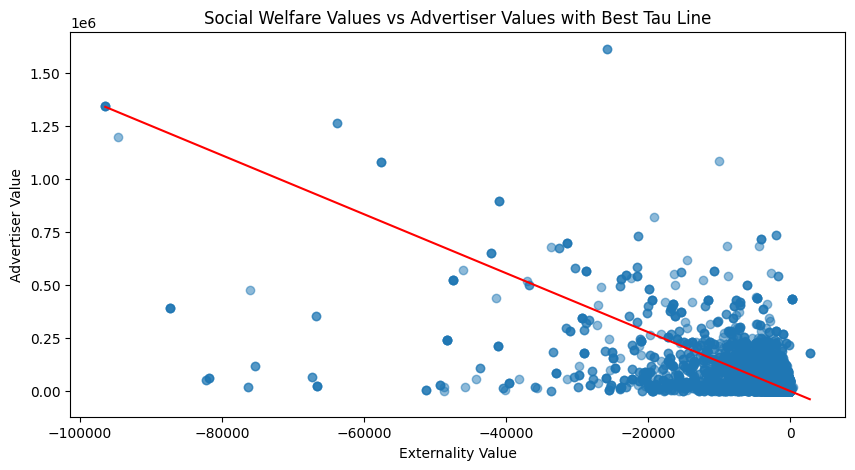

In [14]:
num_auctions = 500
num_advertisers = 50
slope_magnitude_max = 15
slope_step_size = 0.1
intercept_min = -700
intercept_max = -500
intercept_step_size = 10
k=1

advertiser_scaler = tweet_data['action_per_month'].abs().max()
externality_scaler = tweet_data['ext_dollars_per_month'].abs().max()

tweet_data['v'] = tweet_data['action_per_month']# / advertiser_scaler
tweet_data['e'] = tweet_data['ext_dollars_per_month']# / externality_scaler

random_seed = 1234
rng = np.random.default_rng(random_seed)

auction_output = run_auctions(
    num_auctions, 
    num_advertisers, 
    slope_magnitude_max, 
    slope_step_size,
    intercept_min,
    intercept_max,
    intercept_step_size,
    data=tweet_data, 
    k=k, 
    rng=rng)
print_stats(auction_output)#, advertiser_scaler, externality_scaler)
plot_auctions(auction_output)#, advertiser_scaler, externality_scaler)
plot_advertisers(auction_output)#, advertiser_scaler, externality_scaler)

C:\Users\gabem\Repos\XAnalysis\.venv\lib\site-packages\pygad\visualize\plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


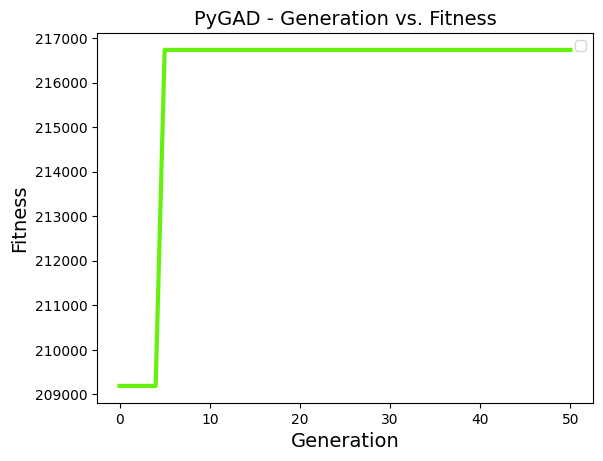

Best line found: y = -0.01719 x + -0.09097
Fitness: 216734.4075019946

Welfare Averages
Avg. VCG Advertiser Welfare: 290785.48
Avg. Collateralized Advertiser Welfare: 282037.37
Avg. VCG Social Welfare: -8159625.13
Avg. Collateralized Social Welfare: -6530296.38

Avg. Change in Advertiser Welfare: -8748.11
Avg. Change in Social Welfare: 1629328.75

Avg. VCG Total Welfare: -7868839.65
Avg. Collateralized Total Welfare: -6248259.01
Avg. Change in Total Welfare: 1620580.64



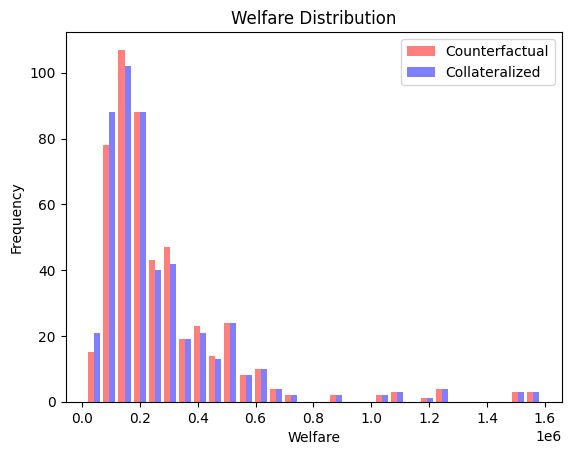

C:\Users\gabem\AppData\Local\Temp\ipykernel_28492\4238403920.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\gabem\AppData\Local\Temp\ipykernel_28492\4238403920.py:176: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


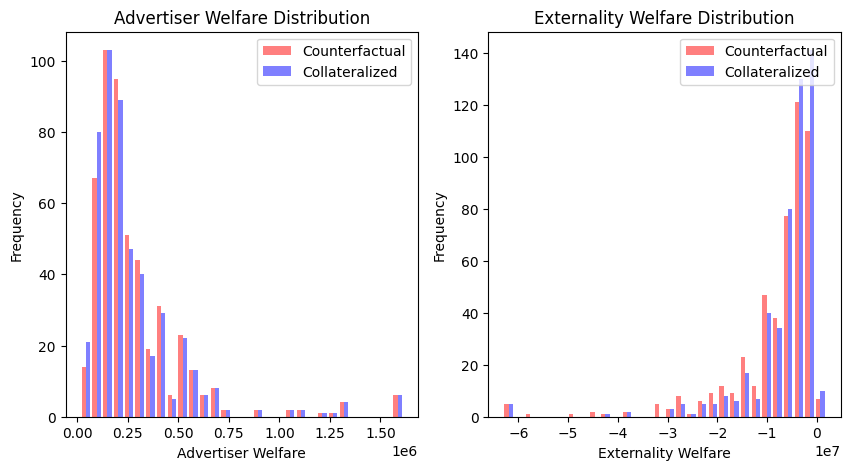

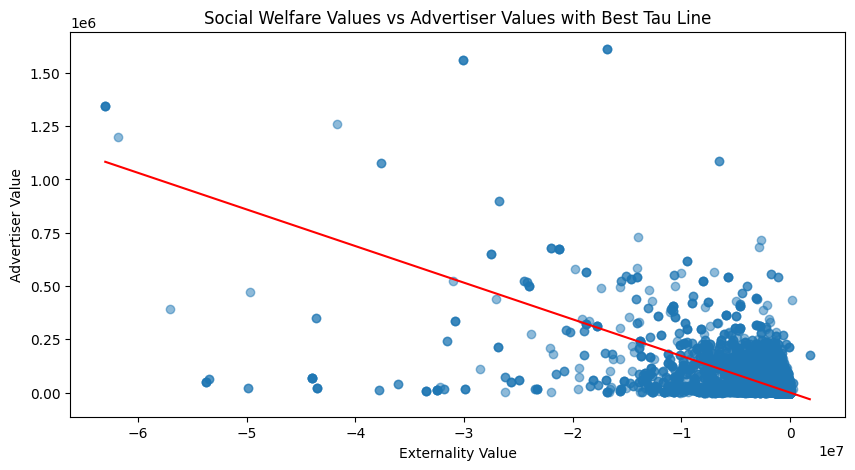

In [28]:
def run_ga():
    tweet_data['v'] = tweet_data['action_per_month']# / advertiser_scaler
    tweet_data['e'] = tweet_data['ext_per_month']# / externality_scaler
    externality_cost = 0.01
    gene_space = [
        # m
        { 'low': -20, 'high': 0 },
        # b
        { 'low': -1000, 'high': 0 }
    ]
    advertisers = [ad_distribution(tweet_data, num_advertisers, rng) for _ in range(num_auctions)]
    k=1
    random_seed = 1234
    
    def run_auction_set_fitness(ga_instance, line, solution_idx):
        w_coll = []
        m, b = line
        tau = lambda v, e: m*e + b
            
        for advertiser_set in advertisers:
                _, w_coll_i = run_auction(advertiser_set, tau, k)
                w_coll.append(w_coll_i)
                
        w_coll_objective = [auction_objective(w, externality_cost) for w in w_coll]
        
        avg_coll_objective = np.mean(w_coll_objective)
        
        return avg_coll_objective
    
    last_fitness = 0
    def on_generation(ga_instance):
        global last_fitness
        print(f"Generation = {ga_instance.generations_completed}")
        print(f"Fitness    = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]}")
        print(f"Change     = {ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1] - last_fitness}")
        last_fitness = ga_instance.best_solution(pop_fitness=ga_instance.last_generation_fitness)[1]
    
    
    
    ga_instance = pygad.GA(
        num_generations=50,
        num_parents_mating=10,
        fitness_func=run_auction_set_fitness,
        sol_per_pop=20,
        num_genes=2,
        gene_space=None,
        parent_selection_type='tournament',
        mutation_type="random",
        mutation_percent_genes=100,
        crossover_type='single_point',
        on_generation=None,
        random_seed=random_seed
    )
    
    ga_instance.run()
    ga_instance.plot_fitness()
    best_solution, best_fitness, _ = ga_instance.best_solution()
    m_opt, b_opt = best_solution
    
    print("Best line found: y = {:.5f} x + {:.5f}".format(m_opt, b_opt))
    print("Fitness:", best_fitness)
    
    best_results = run_auction_set(m_opt, b_opt, advertisers, k)
    best_m, best_b, best_avg_coll_welfare, best_avg_vcg_welfare, best_coll_welfare, best_vcg_welfare, best_individual_welfares = best_results
    best_line = (m_opt, b_opt)
    auction_output = {
            'advertisers': advertisers,
            'tau': best_line,
            'avg_coll_welfare': best_avg_coll_welfare,
            'avg_vcg_welfare': best_avg_vcg_welfare,
            'coll_welfare': best_coll_welfare,
            'vcg_welfare': best_vcg_welfare,
            'individual_welfares': best_individual_welfares
        }
    print_stats(auction_output)
    plot_auctions(auction_output)
    plot_advertisers(auction_output)
    
run_ga()